<a href="https://colab.research.google.com/github/unica-ml/ml/blob/master/notebooks/lab05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks with PyTorch

This notebook provides a brief introduction to PyTorch, inspired from the PyTorch tutorials available at https://github.com/yunjey/pytorch-tutorial and https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.

Let's start with tensors, autograd/autodiff and to/from numpy conversions.

In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


# ================================================================== #
#                        Basic autograd example                      #
# ================================================================== #

# Create tensors.
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2 
print(w.grad)    # w.grad = 1 
print(b.grad)    # b.grad = 1 


# ================================================================== #
#                        Loading data from numpy                     #
# ================================================================== #

# Create a numpy array.
x = np.array([[1, 2], [3, 4]])

# Convert the numpy array to a torch tensor.
y = torch.from_numpy(x)

# Convert the torch tensor to a numpy array.
z = y.numpy()

print("x: ", x)
print("y: ", y)
print("z: ", z)

tensor(2.)
tensor(1.)
tensor(1.)
x:  [[1 2]
 [3 4]]
y:  tensor([[1, 2],
        [3, 4]])
z:  [[1 2]
 [3 4]]


## Logistic/Softmax Classifier on MNIST data

We aim to learn a multiclass linear classifier $f(x) = Wx+b$ on the MNIST dataset, where we have $d=28 \times 28=784$ pixels as inputs, and we aim to predict $k=10$ values (one output per class), i.e., $f(x) : R^d \mapsto R^k$.

To learn the classifier parameters $W \in R^{k \times d}, b \in R^k$, we minimize the cross-entropy loss on the softmax-scaled $k$ outputs:

$$\min_{W,b} L(\mathcal D, W, b) = -\sum_{i=1}^{n} \sum_{c=1}^{k} y_{i c} \cdot \log \left( \sigma(f_{c}(x_i; W, b))\right),$$

where $\mathcal D = (x_i, y_i)_{i=1}^n$ is the training set, $\sigma$ is the softmax operator, and $y_{ic}$ is 1 if the training sample $x_i$ belongs to class $c$ and 0 otherwise (one-hot label encoding of $y_i$).

More details (including gradient computation) at: https://peterroelants.github.io/posts/cross-entropy-softmax/.


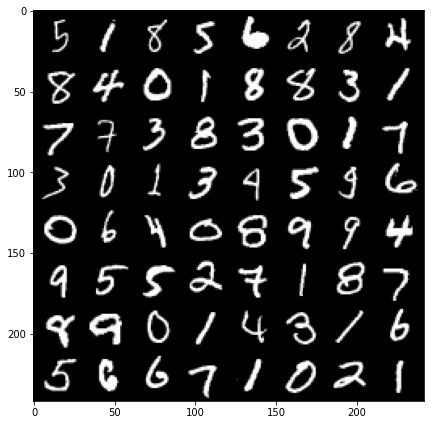

In [0]:
# Hyper-parameters 
input_size = 28 * 28    # 784
num_classes = 10
batch_size = 64

# set CPU or GPU, if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.figure(figsize=(7,10))
imshow(torchvision.utils.make_grid(images, nrow=8))



In [0]:
# Hyper-parameters 
num_epochs = 2
learning_rate = 0.001

# Logistic regression model
model = nn.Linear(input_size, num_classes).to(device)

# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
loss_path = np.zeros(shape=(num_epochs,total_step))
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss_path[epoch][i] = loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))



Epoch [1/2], Step [100/938], Loss: 2.2098
Epoch [1/2], Step [200/938], Loss: 2.1292
Epoch [1/2], Step [300/938], Loss: 2.0584
Epoch [1/2], Step [400/938], Loss: 1.9288
Epoch [1/2], Step [500/938], Loss: 1.8840
Epoch [1/2], Step [600/938], Loss: 1.7852
Epoch [1/2], Step [700/938], Loss: 1.6696
Epoch [1/2], Step [800/938], Loss: 1.6102
Epoch [1/2], Step [900/938], Loss: 1.6238
Epoch [2/2], Step [100/938], Loss: 1.6056
Epoch [2/2], Step [200/938], Loss: 1.4597
Epoch [2/2], Step [300/938], Loss: 1.3716
Epoch [2/2], Step [400/938], Loss: 1.3599
Epoch [2/2], Step [500/938], Loss: 1.3436
Epoch [2/2], Step [600/938], Loss: 1.2618
Epoch [2/2], Step [700/938], Loss: 1.3426
Epoch [2/2], Step [800/938], Loss: 1.2091
Epoch [2/2], Step [900/938], Loss: 1.2264


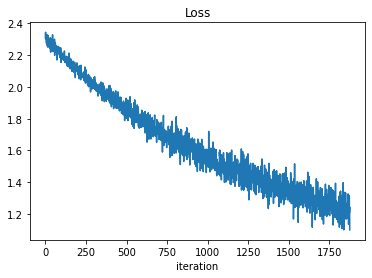

In [0]:
plt.figure()
plt.plot(loss_path.ravel())
plt.title('Loss')
plt.xlabel("iteration")
plt.show()

In [0]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'
          .format(100.0 * correct / total))

Accuracy of the model on the 10000 test images: 80.76000213623047 %


## Training a CNN on MNIST

In [0]:
# Hyper-parameters 
num_epochs = 2
learning_rate = 0.001

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
loss_path = np.zeros(shape=(num_epochs,total_step))
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss_path[epoch][i] = loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/2], Step [100/938], Loss: 0.1906
Epoch [1/2], Step [200/938], Loss: 0.2524
Epoch [1/2], Step [300/938], Loss: 0.1216
Epoch [1/2], Step [400/938], Loss: 0.0783
Epoch [1/2], Step [500/938], Loss: 0.0643
Epoch [1/2], Step [600/938], Loss: 0.0177
Epoch [1/2], Step [700/938], Loss: 0.1139
Epoch [1/2], Step [800/938], Loss: 0.0489
Epoch [1/2], Step [900/938], Loss: 0.0109
Epoch [2/2], Step [100/938], Loss: 0.0221
Epoch [2/2], Step [200/938], Loss: 0.0057
Epoch [2/2], Step [300/938], Loss: 0.0734
Epoch [2/2], Step [400/938], Loss: 0.0873
Epoch [2/2], Step [500/938], Loss: 0.0296
Epoch [2/2], Step [600/938], Loss: 0.0691
Epoch [2/2], Step [700/938], Loss: 0.0164
Epoch [2/2], Step [800/938], Loss: 0.0274
Epoch [2/2], Step [900/938], Loss: 0.0491


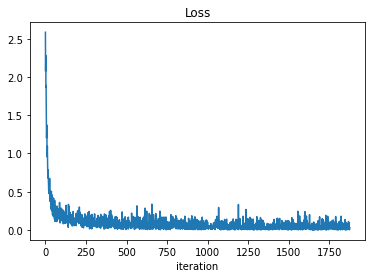

In [0]:
plt.figure()
plt.plot(loss_path.ravel())
plt.title('Loss')
plt.xlabel("iteration")
plt.show()

In [0]:
# Test the model
# eval mode (batchnorm uses moving mean/var instead of mini-batch mean/var)
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'
          .format(100.0 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.28 %


## Training a CNN on CIFAR10

Source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 

Files already downloaded and verified
Files already downloaded and verified
horse   dog plane  bird  ship  bird   dog plane


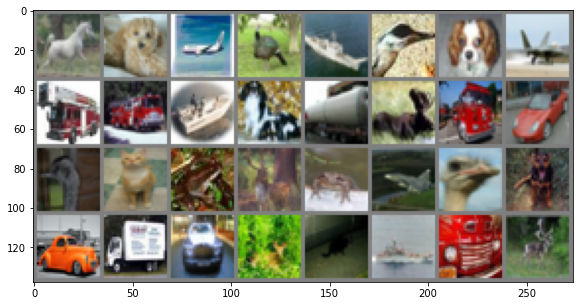

In [0]:
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print labels for the first 8 images
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

# show images
plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))

In [0]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.314
[1,   200] loss: 2.293
[1,   300] loss: 2.304
[1,   400] loss: 2.307
[1,   500] loss: 2.299
[1,   600] loss: 2.299
[1,   700] loss: 2.300
[1,   800] loss: 2.289
[1,   900] loss: 2.292
[1,  1000] loss: 2.295
[1,  1100] loss: 2.278
[1,  1200] loss: 2.280
[1,  1300] loss: 2.172
[1,  1400] loss: 2.237
[1,  1500] loss: 2.042
[2,   100] loss: 2.152
[2,   200] loss: 2.052
[2,   300] loss: 2.142
[2,   400] loss: 1.721
[2,   500] loss: 2.056
[2,   600] loss: 2.097
[2,   700] loss: 1.707
[2,   800] loss: 1.704
[2,   900] loss: 1.933
[2,  1000] loss: 1.684
[2,  1100] loss: 2.034
[2,  1200] loss: 1.776
[2,  1300] loss: 1.629
[2,  1400] loss: 1.687
[2,  1500] loss: 1.586
Finished Training


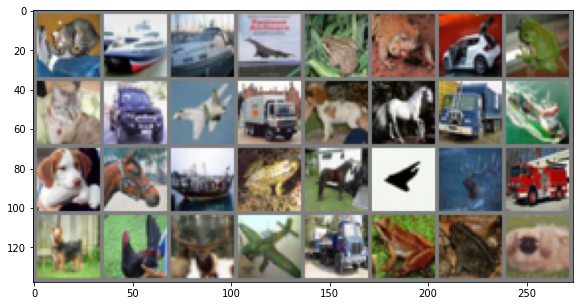

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# per-class accuracies
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 38 %
Accuracy of plane : 56 %
Accuracy of   car : 52 %
Accuracy of  bird : 23 %
Accuracy of   cat : 28 %
Accuracy of  deer : 16 %
Accuracy of   dog : 35 %
Accuracy of  frog : 57 %
Accuracy of horse : 35 %
Accuracy of  ship : 37 %
Accuracy of truck : 41 %


## Pretrained ImageNet models and Adversarial Examples

We use torchvision here to download and use a pretrained ImageNet model.

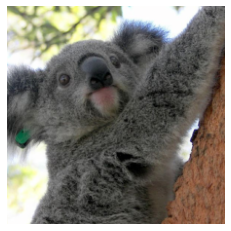

In [0]:
import io
import json

import matplotlib.pyplot as plt
import numpy as np

import requests
import torch
from PIL import Image
from torchvision import transforms, models
from decimal import Decimal

# Download and cache pretrained model from PyTorch model zoo
model = models.resnet18(pretrained=True)
# Set the model in evaluation mode (e.g., disable dropout)
model.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# we need this later for bringing the image back to input space
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225])

# download a sample image from the web
img_path = "https://github.com/ajschumacher/imagen/blob/master/" \
           "imagen/n01882714_4157_koala_bear.jpg?raw=true"
r1 = requests.get(img_path)
img = Image.open(io.BytesIO(r1.content))

# apply transform from torchvision
input_tensor = normalize(transform(img))

# functions to show an image
def imshow(img):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

imshow(input_tensor)

In [0]:
# create a mini-batch as expected by the model
input_batch = input_tensor.unsqueeze(0)  

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print("Output shape", output.shape)

# softmax will rescale outputs so that the sum is 1 and we 
# can use them as probability scores
scores = torch.softmax(output, dim=1)

# take top k predictions - accuracy is usually measured with top-5
_, preds = output.topk(k=5, dim=1)

# Get the list of labels
imagenet_labels_path = "https://raw.githubusercontent.com/" \
                       "anishathalye/imagenet-simple-labels/" \
                       "master/imagenet-simple-labels.json"
r2 = requests.get(imagenet_labels_path)
labels = json.load(io.StringIO(r2.text))

# use the output as index for the labels list
for label in preds[0]:
    predicted_label = labels[label.item()]
    score = scores[0, label.item()].item()
    print("Label: {:25s} Score: {:.2f}".format(predicted_label, Decimal(score)))

Output shape torch.Size([1, 1000])
Label: koala                     Score: 0.97
Label: ring-tailed lemur         Score: 0.02
Label: indri                     Score: 0.01
Label: snow leopard              Score: 0.00
Label: titi                      Score: 0.00


Now we run an adversarial attack!

ID: 105 Label: koala                     Score: 0.97
ID: 383 Label: ring-tailed lemur         Score: 0.02
ID: 384 Label: indri                     Score: 0.01
ID: 289 Label: snow leopard              Score: 0.00
ID: 380 Label: titi                      Score: 0.00


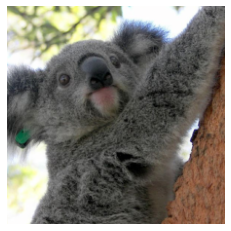

ID: 402 Label: acoustic guitar           Score: 0.86
ID: 546 Label: electric guitar           Score: 0.04
ID: 420 Label: banjo                     Score: 0.01
ID: 889 Label: violin                    Score: 0.01
ID: 105 Label: koala                     Score: 0.01


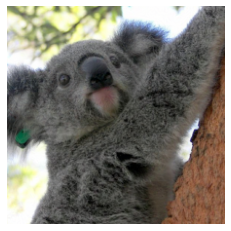

In [0]:
# ================================================================== #
#                        Adversarial Example                         #
# ================================================================== #

def predict(model, x, labels):
    with torch.no_grad():
        output = model(x)  # 1000 values (predictions on 1,000 classes)

    # softmax will rescale outputs so that the sum is 1 and we
    # can use them as probability scores
    scores = torch.softmax(output, dim=1)

    # take top k predictions - accuracy is usually measured with top-5
    _, preds = output.topk(k=5, dim=1)

    # use the output as index for the labels list
    for label in preds[0]:
        predicted_label = labels[label.item()]
        score = scores[0, label.item()].item()
        print("ID: {:3d} Label: {:25s} Score: {:.2f}"
              "".format(label.item(), predicted_label, Decimal(score)))


predict(model, input_batch, labels)
imshow(input_batch[0])


def normalize_l2(x):
    return x / x.view(x.shape[0], -1).norm(p=2, dim=1)


def perturb_iterative(x, y, model, nb_iter, eps_iter, loss_fn,
                      transform, inverse_transform,
                      clip_min=0.0, clip_max=1.0):
    """
    Iteratively maximize the loss over the input.

    :param x: input data.
    :param y: target label.
    :param model: model to run forward pass function.
    :param nb_iter: number of iterations.
    :param eps_iter: attack step size.
    :param loss_fn: loss function.
    :param transform: transformation to apply to the samples.
    :param inverse_transform: inverse process for bringing the samples
        back to input space.
    :param clip_min: mininum value per input dimension.
    :param clip_max: maximum value per input dimension.
    :return: tensor containing the perturbed input.
    """
    delta = torch.zeros_like(x)
    delta.requires_grad_()
    for ii in range(nb_iter):
        outputs = model(x + delta)
        loss = loss_fn(outputs, y)
        loss.backward()

        grad = normalize_l2(delta.grad.data)
        delta.data = delta.data - eps_iter * grad

        # clip for ensuring the sample is in the input space
        perturbed = x.data + delta.data
        perturbed = inverse_transform(perturbed.squeeze())
        perturbed_clip = transform(torch.clamp(perturbed, clip_min, clip_max))
        delta.data =  perturbed_clip - x.data
        delta.grad.data.zero_()

    x_adv = x + delta

    # we need to detach the gradient
    return x_adv.detach()


loss = torch.nn.CrossEntropyLoss()
target_label = torch.LongTensor([402])
x_adv = perturb_iterative(x=input_batch, y=target_label, model=model,
                          nb_iter=20, eps_iter=0.5, loss_fn=loss,
                          transform=normalize,
                          inverse_transform=inv_normalize,
                          clip_min=0.0,
                          clip_max=1.0)

predict(model, x_adv, labels)
imshow(x_adv[0])